## Module 5: Analyse, diagnose and improve a model​

In the excercise of this week you will be working with financial data in order to (hopefully) find a portfolio of equities which outperform SP500. The data that you are gonna work with has two main sources: 
* Financial data from the companies extracted from the quarterly company reports (mostly extracted from [macrotrends](https://www.macrotrends.net/) so you can use this website to understand better the data and get insights on the features, for example [this](https://www.macrotrends.net/stocks/charts/AAPL/apple/revenue) is the one corresponding to APPLE)
* Stock prices, mostly extracted from [morningstar](https://indexes.morningstar.com/page/morningstar-indexes-empowering-investor-success?utm_source=google&utm_medium=cpc&utm_campaign=MORNI%3AG%3ASearch%3ABrand%3ACore%3AUK%20MORNI%3ABrand%3ACore%3ABroad&utm_content=engine%3Agoogle%7Ccampaignid%3A18471962329%7Cadid%3A625249340069&utm_term=morningstar%20index&gclid=CjwKCAjws9ipBhB1EiwAccEi1Fu6i20XHVcxFxuSEtJGF0If-kq5-uKnZ3rov3eRkXXFfI5j8QBtBBoCayEQAvD_BwE), which basically tell us how the stock price is evolving so we can use it both as past features and the target to predict).

Before going to the problem that we want to solve, let's comment some of the columns of the dataset:


* `Ticker`: a [short name](https://en.wikipedia.org/wiki/Ticker_symbol) to identify the equity (that you can use to search in macrotrends)
* `date`: the date of the company report (normally we are gonna have 1 every quarter). This is for informative purposes but you can ignore it when modeling.
* `execution date`: the date when we would had executed the algorithm for that equity. We want to execute the algorithm once per quarter to create the portfolio, but the release `date`s of all the different company reports don't always match for the quarter, so we just take a common `execution_date` for all of them.
* `stock_change_div_365`: what is the % change of the stock price (with dividens) in the FOLLOWING year after `execution date`. 
* `sp500_change_365`: what is the % change of the SP500 in the FOLLOWING year after `execution date`.
* `close_0`: what is the price at the moment of `execution date`
* `stock_change__minus_120` what is the % change of the stock price in the last 120 days
* `stock_change__minus_730`: what is the % change of the stock price in the last 730 days

The rest of the features can be divided beteween financial features (the ones coming from the reports) and technical features (coming from the stock price). We leave the technical features here as a reference: 

In [86]:
technical_features = ['close_0', 'close_sp500_0', 'close_365', 'close_sp500_365',
       'close__minus_120', 'close_sp500__minus_120', 'close__minus_365',
       'close_sp500__minus_365', 'close__minus_730', 'close_sp500__minus_730',
       'stock_change_365','stock_change_div_365', 'sp500_change_365', 'stock_change__minus_120',
       'sp500_change__minus_120', 'stock_change__minus_365',
       'sp500_change__minus_365', 'stock_change__minus_730','sp500_change__minus_730',
       'std__minus_365','std__minus_730','std__minus_120']

The problem that we want to solve is basically find a portfolio of `top_n` tickers (initially set to 10) to invest every `execution date` (basically once per quarter) and the goal is to have a better return than `SP500` in the following year. The initial way to model this is to have a binary target which is 1 when `stock_change_div_365` - `sp500_change_365` (the difference between the return of the equity and the SP500 in the following year) is positive or 0 otherwise. So we try to predict the probability of an equity of improving SP500 in the following year, we take the `top_n` equities and compute their final return.

In [87]:
import pandas as pd
import re
import numpy as np
import lightgbm as lgb
from plotnine import ggplot, geom_histogram, aes, geom_col, coord_flip,geom_bar,scale_x_discrete, geom_point, theme,element_text

In [88]:
# number of trees in lightgbm
n_trees = 40
minimum_number_of_tickers = 1500
# Number of the quarters in the past to train
n_train_quarters = 36
# number of tickers to make the portfolio
top_n = 10

# 1. Cargar datos y preprocesamiento inicial

In [89]:
data_set = pd.read_feather("../../data/financials_against_return.feather")

In [90]:
pd.set_option('display.max_columns', None)

In [91]:
data_set.head()

,Ticker,date,AssetTurnover,CashFlowFromFinancialActivities,CashFlowFromInvestingActivities,CashFlowFromOperatingActivities,CashOnHand,ChangeInAccountsPayable,ChangeInAccountsReceivable,ChangeInAssetsLiabilities,ChangeInInventories,CommonStockDividendsPaid,CommonStockNet,ComprehensiveIncome,CostOfGoodsSold,CurrentRatio,DaysSalesInReceivables,DebtIssuanceRetirementNet_minus_Total,DebtEquityRatio,EBIT,EBITMargin,EBITDA,EBITDAMargin,FinancialActivities_minus_Other,GoodwillAndIntangibleAssets,GrossMargin,GrossProfit,IncomeAfterTaxes,IncomeFromContinuousOperations,IncomeFromDiscontinuedOperations,IncomeTaxes,Inventory,InventoryTurnoverRatio,InvestingActivities_minus_Other,LongTermDebt,Long_minus_TermInvestments,Long_minus_termDebtCapital,NetAcquisitionsDivestitures,NetCashFlow,NetChangeInIntangibleAssets,NetChangeInInvestments_minus_Total,NetChangeInLong_minus_TermInvestments,NetChangeInPropertyPlantAndEquipment,NetChangeInShort_minus_termInvestments,NetCommonEquityIssuedRepurchased,NetCurrentDebt,NetIncome,NetIncomeLoss,NetLong_minus_TermDebt,NetProfitMargin,NetTotalEquityIssuedRepurchased,OperatingExpenses,OperatingIncome,OperatingMargin,OtherCurrentAssets,OtherIncome,OtherLong_minus_TermAssets,OtherNon_minus_CashItems,OtherNon_minus_CurrentLiabilities,OtherOperatingIncomeOrExpenses,OtherShareHoldersEquity,Pre_minus_PaidExpenses,Pre_minus_TaxIncome,Pre_minus_TaxProfitMargin,PropertyPlantAndEquipment,ROA_minus_ReturnOnAssets,ROE_minus_ReturnOnEquity,ROI_minus_ReturnOnInvestment,Receivables,ReceiveableTurnover,ResearchAndDevelopmentExpenses,RetainedEarningsAccumulatedDeficit,ReturnOnTangibleEquity,Revenue,SGAExpenses,ShareHolderEquity,Stock_minus_BasedCompensation,TotalAssets,TotalChangeInAssetsLiabilities,TotalCommonAndPreferredStockDividendsPaid,TotalCurrentAssets,TotalCurrentLiabilities,TotalDepreciationAndAmortization_minus_CashFlow,TotalLiabilities,TotalLiabilitiesAndShareHoldersEquity,TotalLongTermLiabilities,TotalLong_minus_TermAssets,TotalNon_minus_CashItems,TotalNon_minus_OperatingIncomeExpense,execution_date,close_0,close_sp500_0,stock_change_365,stock_change_div_365,sp500_change_365,stock_change_730,stock_change_div_730,sp500_change_730,stock_change__minus_120,stock_change_div__minus_120,sp500_change__minus_120,stock_change__minus_365,stock_change_div__minus_365,sp500_change__minus_365,stock_change__minus_730,stock_change_div__minus_730,sp500_change__minus_730,std_730,std__minus_120,std__minus_365,std__minus_730,Market_cap,n_finan_prev_year,Enterprisevalue,EBITDAEV,EBITEV,RevenueEV,CashOnHandEV,PFCF,PE,PB,RDEV,WorkingCapital,ROC,DividendYieldLastYear,EPS_minus_EarningsPerShare_change_1_years,EPS_minus_EarningsPerShare_change_2_years,FreeCashFlowPerShare_change_1_years,FreeCashFlowPerShare_change_2_years,OperatingCashFlowPerShare_change_1_years,OperatingCashFlowPerShare_change_2_years,EBITDA_change_1_years,EBITDA_change_2_years,EBIT_change_1_years,EBIT_change_2_years,Revenue_change_1_years,Revenue_change_2_years,NetCashFlow_change_1_years,NetCashFlow_change_2_years,CurrentRatio_change_1_years,CurrentRatio_change_2_years,Market_cap__minus_365,Market_cap__minus_730,diff_ch_sp500
0,A,2005-01-31,0.1695,81.000,-57.000,137.000,2483.0000,5.000,44.000,-5.000,-13.000,NaN,5.000,215.000,621.000,2.6251,70.2475,23.000,0.3052,152.0000,3.1353,344.0000,NaN,NaN,459.000,48.7624,591.0000,43.0000,51.0000,52.0,15.000,1037.000,0.5988,-9.000,1150.000,NaN,0.2338,-10.000,672.000,NaN,-10.000,-10.000,-28.000,NaN,58.000,23.000,103.0000,103.000,NaN,8.4984,58.000,1174.000,38.0000,3.1353,183.000,NaN,807.000,33.000,461.000,NaN,NaN,NaN,58.0000,4.7855,1235.000,0.7133,1.3535,1.0370,946.000,1.2812,700.0,-1707.0000,1.5413,4848.0000,378.000,3768.0000,1.0,7150.0000,-47.000,NaN,4649.0000,1771.000,48.000,3382.000,7150.0000,1611.000,2501.000,81.000,20.0000,2005-06-30,15.5105,1191.32761,0.370982,0.370982,0.066209,0.772214,0.772214,0.26191,0.057341,0.057341,0.015743,0.271937,0.271937,-0.042383,-0.135100,-0.135100,-0.175443,0.017009,0.014371,0.020641,0.021253,7693.20

In [32]:
data_set.shape

(170483, 144)

Remove these quarters which have les than `minimum_number_of_tickers` tickers:

In [92]:
df_quarter_lengths = data_set.groupby(["execution_date"]).size().reset_index().rename(columns = {0:"count"})
data_set = pd.merge(data_set, df_quarter_lengths, on = ["execution_date"])
data_set = data_set[data_set["count"]>=minimum_number_of_tickers]

In [93]:
data_set.shape

(170483, 145)

Create the target:

In [96]:
data_set["diff_ch_sp500"] = data_set["stock_change_div_365"] - data_set["sp500_change_365"]
data_set.loc[data_set["diff_ch_sp500"]>0,"target"] = 1
data_set.loc[data_set["diff_ch_sp500"]<0,"target"] = 0

data_set["target"].value_counts()

target
0.0    82437
1.0    73829
Name: count, dtype: int64

In [39]:
data_set.head()

,Ticker,date,AssetTurnover,CashFlowFromFinancialActivities,CashFlowFromInvestingActivities,CashFlowFromOperatingActivities,CashOnHand,ChangeInAccountsPayable,ChangeInAccountsReceivable,ChangeInAssetsLiabilities,ChangeInInventories,CommonStockDividendsPaid,CommonStockNet,ComprehensiveIncome,CostOfGoodsSold,...,EBITDA_change_1_years,EBITDA_change_2_years,EBIT_change_1_years,EBIT_change_2_years,Revenue_change_1_years,Revenue_change_2_years,NetCashFlow_change_1_years,NetCashFlow_change_2_years,CurrentRatio_change_1_years,CurrentRatio_change_2_years,Market_cap__minus_365,Market_cap__minus_730,diff_ch_sp500,count,target
0,A,2005-01-31,0.1695,81.000,-57.000,137.000,2483.0000,5.000,44.000,-5.000,-13.000,NaN,5.000,215.000,621.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.304773,1962,1.0
1,NDSN,2005-01-31,0.2248,-3.366,10.663,7.700,62.6220,NaN,NaN,-21.145,NaN,-5.800,12.253,-4.625,83.625,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.387846,1962,1.0
2,HURC,2005-01-31,0.3782,0.483,-0.400,2.866,11.3030,0.156,0.854,-0.027,-1.487,NaN,0.618,-3.529,20.506,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.543440,1962,1.0
3,NRT,2005-01-31,1.0517,NaN,NaN,NaN,4.9015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.331322,1962,1.0
4,HRL,2005-01-31,0.4880,-12.075,-113.077,83.476,145.2050,NaN,17.084,3.539,-17.176,-15.516,8.100,-23.242,959.363,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.218482,1962,1.0


# 2. Funciones para entrenar y medir rendimiento del modelo

This function computes the main metric that we want to optimize: given a prediction where we have probabilities for each equity, we sort the equities in descending order of probability, we pick the `top_n` ones, and we we weight the returned `diff_ch_sp500` by the probability:

`get_weighted_performance_of_stocks`calcula el retorno promedio ponderado del portfolio

`get_top_ticker_per_prob` selecciona las `top_n` acciones con mayor probabilidad predicha

`top_wt_performance`evalua el retorno del portfolio durante el entrenamiento

In [41]:
def get_weighted_performance_of_stocks(df,metric):
    df["norm_prob"] = 1/len(df)
    return np.sum(df["norm_prob"]*df[metric])

def get_top_tickers_per_prob(preds):
    if len(preds) == len(train_set):
        data_set = train_set.copy()
    elif len(preds) == len(test_set):
        data_set = test_set.copy()
    else:
        assert ("Not matching train/test")
    data_set["prob"] = preds
    data_set = data_set.sort_values(["prob"], ascending = False)
    data_set = data_set.head(top_n)
    return data_set

# main metric to evaluate: average diff_ch_sp500 of the top_n stocks
def top_wt_performance(preds, train_data):
    top_dataset = get_top_tickers_per_prob(preds)
    return "weighted-return", get_weighted_performance_of_stocks(top_dataset,"diff_ch_sp500"), True

We have created for you a function to make the `train` and `test` split based on a `execution_date`:

In [42]:
def split_train_test_by_period(data_set, test_execution_date,include_nulls_in_test = False):
    # we train with everything happening at least one year before the test execution date
    train_set = data_set.loc[data_set["execution_date"] <= pd.to_datetime(test_execution_date) - pd.Timedelta(350, unit = "day")]
    # remove those rows where the target is null
    train_set = train_set[~pd.isna(train_set["diff_ch_sp500"])]
    execution_dates = train_set.sort_values("execution_date")["execution_date"].unique()
    # Pick only the last n_train_quarters
    if n_train_quarters!=None:
        train_set = train_set[train_set["execution_date"].isin(execution_dates[-n_train_quarters:])]
        
    # the test set are the rows happening in the execution date with the concrete frequency
    test_set = data_set.loc[(data_set["execution_date"] == test_execution_date)]
    if not include_nulls_in_test:
        test_set = test_set[~pd.isna(test_set["diff_ch_sp500"])]
    test_set = test_set.sort_values('date', ascending = False).drop_duplicates('Ticker', keep = 'first')
    
    return train_set, test_set

`train_set`: Conjunto de entrenamiento con datos históricos (hasta 350 días antes de test_execution_date), sin valores nulos en diff_ch_sp500, y limitado a los últimos n_train_quarters trimestres.

`test_set`: Conjunto de prueba con datos del test_execution_date, sin valores nulos en diff_ch_sp500 y sin duplicados de Ticker.

Ensure that we don't include features which are irrelevant or related to the target:

In [43]:
def get_columns_to_remove():
    columns_to_remove = [
                         "date",
                         "improve_sp500",
                         "Ticker",
                         "freq",
                         "set",
                         "close_sp500_365",
                         "close_365",
                         "stock_change_365",
                         "sp500_change_365",
                         "stock_change_div_365",
                         "stock_change_730",
                         "sp500_change_365",
                         "stock_change_div_730",
                         "diff_ch_sp500",
                         "diff_ch_avg_500",
                         "execution_date","target","index","quarter","std_730","count"]
        
    return columns_to_remove

This is the main modeling function, it receives a train test and a test set and trains a `lightgbm` in classification mode. We don't recommend to change the main algorithm for this excercise but we suggest to play with its hyperparameters:

In [45]:
import warnings
warnings.filterwarnings('ignore')


def train_model(train_set,test_set,n_estimators = 300):

    columns_to_remove = get_columns_to_remove()
    
    X_train = train_set.drop(columns = columns_to_remove, errors = "ignore")
    X_test = test_set.drop(columns = columns_to_remove, errors = "ignore")
    
    
    y_train = train_set["target"]
    y_test = test_set["target"]

    lgb_train = lgb.Dataset(X_train,y_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
    
    eval_result = {}
    
 
    objective = 'binary'
    metric = 'binary_logloss' 
    params = {
             "random_state":1, 
             "verbosity": -1,
             "n_jobs":10, 
             "n_estimators":n_estimators,
             "objective": objective,
             "metric": metric}
    
    model = lgb.train(params = params,train_set = lgb_train,
                      valid_sets = [lgb_test,lgb_train],
                      feval = [top_wt_performance],
                      callbacks = [lgb.record_evaluation(eval_result = eval_result)])
    return model,eval_result,X_train,X_test
            

This is the function which receives an `execution_date` and splits the dataset between train and test, trains the models and evaluates the model in test. It returns a dictionary with the different evaluation metrics in train and test:

In [47]:
def run_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,n_estimators,include_nulls_in_test = False):
        global train_set
        global test_set
        # split the dataset between train and test
        train_set, test_set = split_train_test_by_period(data_set,execution_date,include_nulls_in_test = include_nulls_in_test)
        train_size, _ = train_set.shape
        test_size, _ = test_set.shape
        model = None
        X_train = None
        X_test = None
        
        # if both train and test are not empty
        if train_size > 0 and test_size>0:
            model, evals_result, X_train, X_test = train_model(train_set,
                                                              test_set,
                                                              n_estimators = n_estimators)
            
            test_set['prob'] = model.predict(X_test)
            predicted_tickers = test_set.sort_values('prob', ascending = False)
            predicted_tickers["execution_date"] = execution_date
            all_results[(execution_date)] = evals_result
            all_models[(execution_date)] = model
            all_predicted_tickers_list.append(predicted_tickers)
        return all_results,all_predicted_tickers_list,all_models,model,X_train,X_test




Obtiene todas las fechas del dataset 

In [ ]:

execution_dates = np.sort( data_set['execution_date'].unique() )

array(['2005-06-30T00:00:00.000000000', '2005-09-30T00:00:00.000000000',
       '2005-12-30T00:00:00.000000000', '2006-03-31T00:00:00.000000000',
       '2006-06-30T00:00:00.000000000', '2006-09-30T00:00:00.000000000',
       '2006-12-30T00:00:00.000000000', '2007-03-31T00:00:00.000000000',
       '2007-06-30T00:00:00.000000000', '2007-09-30T00:00:00.000000000',
       '2007-12-30T00:00:00.000000000', '2008-03-31T00:00:00.000000000',
       '2008-06-30T00:00:00.000000000', '2008-09-30T00:00:00.000000000',
       '2008-12-30T00:00:00.000000000', '2009-03-31T00:00:00.000000000',
       '2009-06-30T00:00:00.000000000', '2009-09-30T00:00:00.000000000',
       '2009-12-30T00:00:00.000000000', '2010-03-31T00:00:00.000000000',
       '2010-06-30T00:00:00.000000000', '2010-09-30T00:00:00.000000000',
       '2010-12-30T00:00:00.000000000', '2011-03-31T00:00:00.000000000',
       '2011-06-30T00:00:00.000000000', '2011-09-30T00:00:00.000000000',
       '2011-12-30T00:00:00.000000000', '2012-03-31

This is the main training loop: it goes through each different `execution_date` and calls `run_model_for_execution_date`. All the results are stored in `all_results` and the predictions in `all_predicted_tickers_list`.

In [49]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}

for execution_date in execution_dates:
    print(execution_date)
    all_results,all_predicted_tickers_list,all_models,model,X_train,X_test = run_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,n_trees,False)
all_predicted_tickers = pd.concat(all_predicted_tickers_list) 

2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-06-30T00:00:00.000000000
2013-09-30

In [98]:
all_predicted_tickers.head(5)

,Ticker,date,AssetTurnover,CashFlowFromFinancialActivities,CashFlowFromInvestingActivities,CashFlowFromOperatingActivities,CashOnHand,ChangeInAccountsPayable,ChangeInAccountsReceivable,ChangeInAssetsLiabilities,ChangeInInventories,CommonStockDividendsPaid,CommonStockNet,ComprehensiveIncome,CostOfGoodsSold,...,EBITDA_change_2_years,EBIT_change_1_years,EBIT_change_2_years,Revenue_change_1_years,Revenue_change_2_years,NetCashFlow_change_1_years,NetCashFlow_change_2_years,CurrentRatio_change_1_years,CurrentRatio_change_2_years,Market_cap__minus_365,Market_cap__minus_730,diff_ch_sp500,count,target,prob
8051,TD,2006-01-31,0.0105,8049.80,-952.120,-6645.170,97038.950,NaN,NaN,NaN,NaN,NaN,5154.850,NaN,1871.680,...,NaN,NaN,NaN,0.265095,NaN,-0.617174,NaN,NaN,NaN,29528.262573,NaN,0.189576,2052,1.0,0.955844
8085,RY,2006-01-31,0.0122,13705.14,-10458.820,-3469.990,126104.100,NaN,NaN,NaN,NaN,NaN,6160.970,NaN,2824.670,...,NaN,NaN,NaN,0.124467,NaN,-0.838614,NaN,NaN,NaN,40256.249510,NaN,0.162328,2052,1.0,0.951718
8177,GS,2006-02-28,0.0137,16873.00,-920.000,-19643.000,363986.000,-5282.000,-2400.000,-313.000,-14689.000,-148.0,6.000,15.0,418.000,...,NaN,0.144172,NaN,0.142311,NaN,-0.777015,NaN,-0.032194,NaN,52550.502000,NaN,0.266628,2052,1.0,0.949645
9460,JPM,2006-03-31,0.0113,53821.00,-34501.000,-19141.000,513228.000,NaN,-125.000,-9752.000,-9330.000,-1215.0,3645.000,-1017.0,8243.000,...,NaN,NaN,NaN,0.103863,NaN,-1.071134,NaN,NaN,NaN,126085.336000,NaN,0.002404,2052,1.0,0.943300
9370,RUSHB,2006-03-31,0.5860,-9.08,-30.061,27.377,121.305,3.425,9.754,0.189,-6.348,NaN,0.248,NaN,416.285,...,NaN,0.518289,NaN,0.219156,NaN,1.096113,NaN,0.045820,NaN,332.501248,NaN,0.055505,2052,1.0,0.940366


In [99]:
all_predicted_tickers.shape

(148083, 147)

In [51]:
def parse_results_into_df(set_):
    df = pd.DataFrame()
    for date in all_results:
        df_tmp = pd.DataFrame(all_results[(date)][set_])
        df_tmp["n_trees"] = list(range(len(df_tmp)))
        df_tmp["execution_date"] = date
        df= pd.concat([df,df_tmp])
    
    df["execution_date"] = df["execution_date"].astype(str)
    
    return df

In [52]:
test_results = parse_results_into_df("valid_0")
train_results = parse_results_into_df("training")

In [109]:
test_results.head(10)

,binary_logloss,weighted-return,n_trees,execution_date
0,0.718962,0.193742,0,2006-06-30
1,0.716195,0.246123,1,2006-06-30
2,0.715489,0.267459,2,2006-06-30
3,0.714979,0.218345,3,2006-06-30
4,0.712628,0.015834,4,2006-06-30
5,0.714413,0.064492,5,2006-06-30
6,0.712609,0.065176,6,2006-06-30
7,0.714529,0.065176,7,2006-06-30
8,0.716325,-0.007136,8,2006-06-30
9,0.713787,0.063985,9,2006-06-30


In [112]:
train_results

,binary_logloss,weighted-return,n_trees,execution_date
0,0.657505,0.267845,0,2006-06-30
1,0.639193,0.483940,1,2006-06-30
2,0.619754,0.218716,2,2006-06-30
3,0.601840,0.247316,3,2006-06-30
4,0.585715,0.250948,4,2006-06-30
...,...,...,...,...
35,0.621253,0.431394,35,2020-03-31
36,0.620597,0.487939,36,2020-03-31
37,0.619887,0.487939,37,2020-03-31
38,0.619180,0.487939,38,2020-03-31


In [ ]:
test_results_final_tree = test_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")
train_results_final_tree = train_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")


In [110]:
test_results_final_tree.head(10)

,binary_logloss,weighted-return,n_trees,execution_date
39,0.759610,0.099404,39,2006-06-30
39,0.730303,0.035528,39,2006-09-30
39,0.715078,-0.052195,39,2006-12-30
39,0.710833,-0.067471,39,2007-03-31
39,0.711701,-0.045395,39,2007-06-30
39,0.813939,0.124543,39,2007-09-30
39,0.841405,0.176348,39,2007-12-30
39,0.773925,0.088931,39,2008-03-31
39,0.768846,-0.076386,39,2008-06-30
39,0.685414,0.105201,39,2008-09-30


In [111]:
train_results_final_tree.head(10)

,binary_logloss,weighted-return,n_trees,execution_date
39,0.276797,0.277172,39,2006-06-30
39,0.393084,0.236828,39,2006-09-30
39,0.446241,0.288516,39,2006-12-30
39,0.479211,0.209679,39,2007-03-31
39,0.496369,0.222281,39,2007-06-30
39,0.509513,0.227303,39,2007-09-30
39,0.515896,0.215768,39,2007-12-30
39,0.532153,0.509451,39,2008-03-31
39,0.542929,0.617720,39,2008-06-30
39,0.553761,0.425047,39,2008-09-30


# Visualización de resultados

And this are the results:

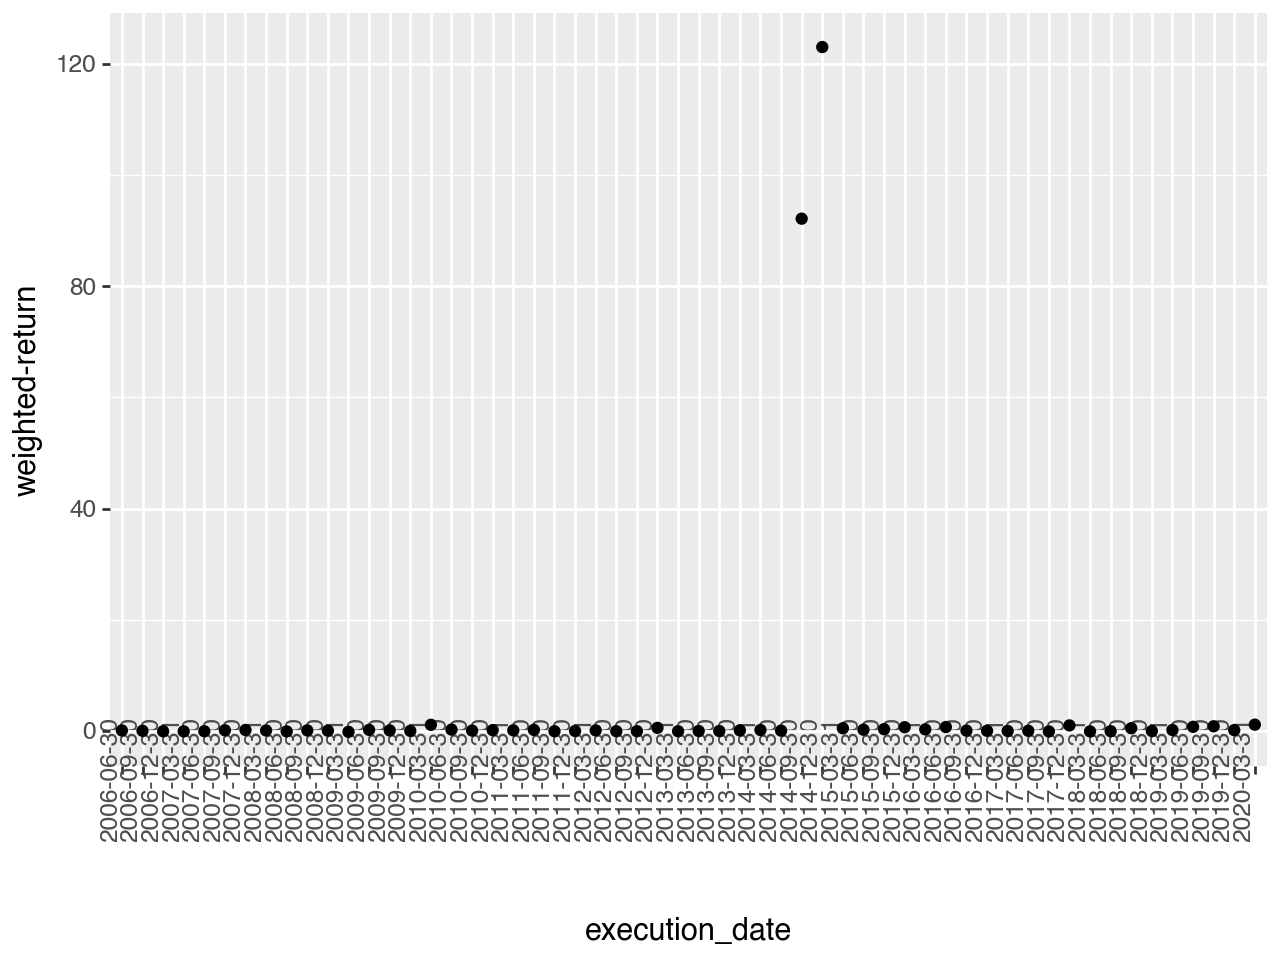

In [58]:
ggplot(test_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))



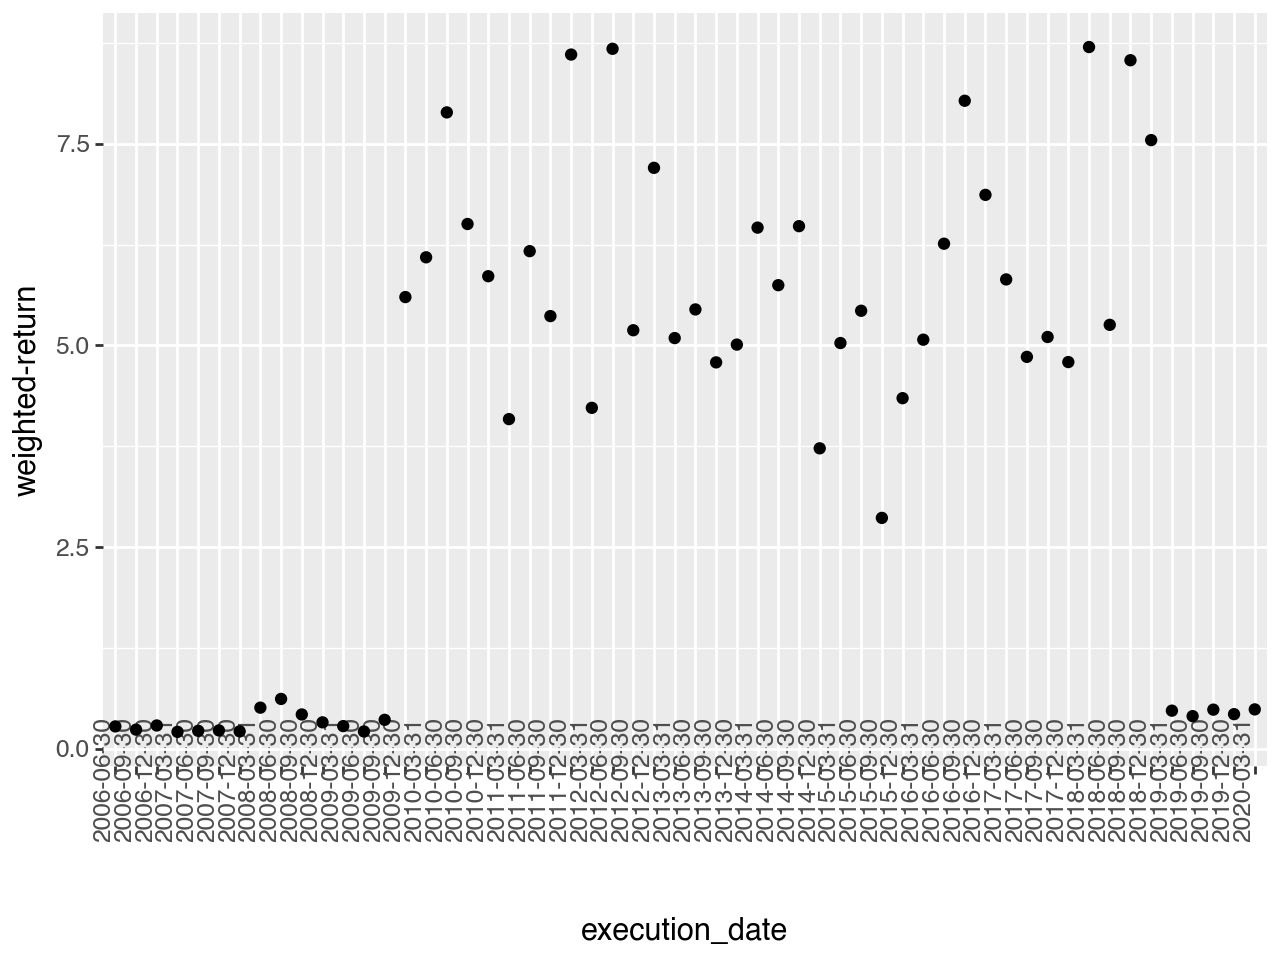

In [59]:
ggplot(train_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))


We have trained the first models for all the periods for you, but there are a lot of things which may be wrong or can be improved. Some ideas where you can start:
* Try to see if there is any kind of data leakage or suspicious features
* If the training part is very slow, try to see how you can modify it to execute faster tests
* Try to understand if the algorithm is learning correctly
* We are using a very high level metric to evaluate the algorithm so you maybe need to use some more low level ones
* Try to see if there is overfitting
* Try to see if there is a lot of noise between different trainings
* To simplify, why if you only keep the first tickers in terms of Market Cap?
* Change the number of quarters to train in the past

This function can be useful to compute the feature importance:

In [81]:
def draw_feature_importance(model,top = 15):
    fi = model.feature_importance()
    fn = model.feature_name()
    feature_importance = pd.DataFrame([{"feature":fn[i],"imp":fi[i]} for i in range(len(fi))])
    feature_importance = feature_importance.sort_values("imp",ascending = False).head(top)
    feature_importance = feature_importance.sort_values("imp",ascending = True)
    plot = ggplot(feature_importance,aes(x = "feature",y  = "imp")) + geom_col(fill = "lightblue") + coord_flip() +  scale_x_discrete(limits = feature_importance["feature"])
    return plot


In [105]:
def draw_feature_importance(model, top=15):
    fi = model.feature_importance()
    fn = model.feature_name()
    
    feature_importance = pd.DataFrame({"feature": fn, "imp": fi})
    feature_importance = feature_importance.sort_values("imp", ascending=False).head(top)
    feature_importance = feature_importance.sort_values("imp", ascending=True)
    
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance["feature"], feature_importance["imp"], color="lightblue")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title("Feature Importance")
    plt.show()

In [71]:
from scipy.stats import lognorm
import matplotlib.pyplot as plt

# Part 2: Solution

Lo primero que me sorprende es la enorme diferencia entre el rendimiento en train y en val, seguramente estemos haciendo overfit .

Quiero ver también la importancia media de las caracteristicas a lo largo de todas las fechas de ejecución

In [107]:
def calculate_mean_feature_importance(all_models, top=15):
    all_feature_importance = pd.DataFrame()

    # Iterar sobre cada modelo y acumular la importancia de las características
    for execution_date, model in all_models.items():
        fi = model.feature_importance()
        fn = model.feature_name()
        feature_importance = pd.DataFrame({"feature": fn, "imp": fi, "execution_date": execution_date})
        all_feature_importance = pd.concat([all_feature_importance, feature_importance])

    # Calcular la importancia media de cada característica
    mean_feature_importance = all_feature_importance.groupby("feature")["imp"].mean().reset_index()
    
    # Seleccionar las top características más importantes
    mean_feature_importance = mean_feature_importance.sort_values("imp", ascending=False).head(top)
    mean_feature_importance = mean_feature_importance.sort_values("imp", ascending=True)
    
    return mean_feature_importance

def plot_mean_feature_importance(mean_feature_importance):
    plt.figure(figsize=(10, 6))
    plt.barh(mean_feature_importance["feature"], mean_feature_importance["imp"], color="lightblue")
    plt.xlabel("Mean Importance")
    plt.ylabel("Feature")
    plt.title("Mean Feature Importance Across All Execution Dates")
    plt.show()

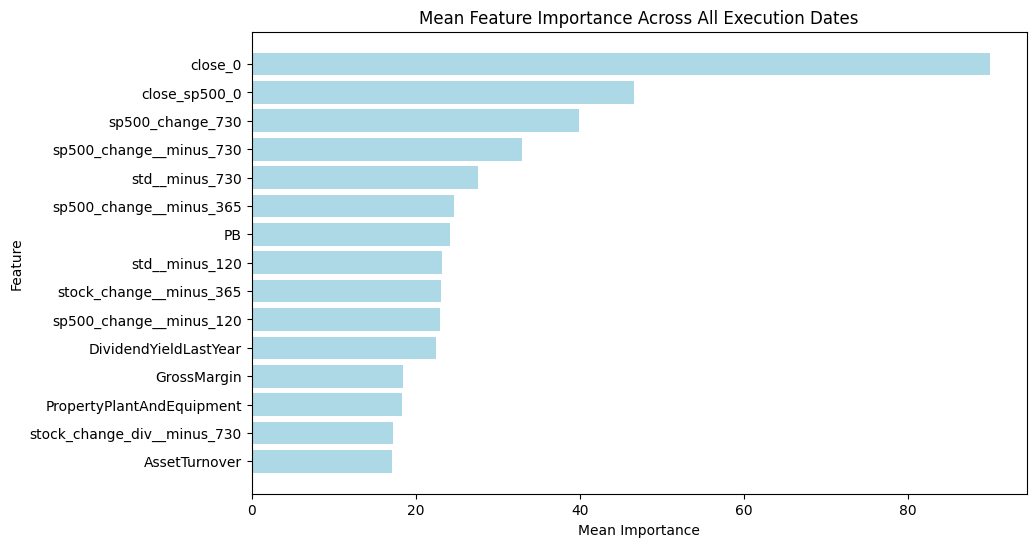

In [108]:
mean_feature_importance = calculate_mean_feature_importance(all_models, top=15)

plot_mean_feature_importance(mean_feature_importance)

El metodo que utiliza LightGBm para calcular feature importance es ver cuanta information gain he ganado al dividir con esa feature concreta. Este tipo de feature importance tiene un sesgo a variables que tienen cardinalidad alta. Variables que aunque no sean muy importantes, voy a tener más probabilidad de escogerla para hacer un split

Las features más importantes son: 

* close_0 : precio de la acción en la execution_date

* close_sp500_o : precio de SP500 en execution_date

* sp500_change_730 :  % change of the SP500 in the FOLLOWING 2 years after `execution date`.

* sp500_change_minus_730 : % change of the SP500 in the last 2 years

El primer problema que veo es utilizar variables del tipo sp500_change_730 o stock_change_div_365, ya que es ***información del futuro***, estamos haciendo data leakage.

Esta feature es la tercera más importante en el modelo.

No esta añadida en columns_to_remove, hay que añadirla

In [ ]:
technical_features = ['close_0', 'close_sp500_0', 'close_365', 'close_sp500_365',
       'close__minus_120', 'close_sp500__minus_120', 'close__minus_365',
       'close_sp500__minus_365', 'close__minus_730', 'close_sp500__minus_730',
       'stock_change_365','stock_change_div_365', 'sp500_change_365', 'stock_change__minus_120',
       'sp500_change__minus_120', 'stock_change__minus_365',
       'sp500_change__minus_365', 'stock_change__minus_730','sp500_change__minus_730',
       'std__minus_365','std__minus_730','std__minus_120']

In [148]:
def get_columns_to_remove():
    columns_to_remove = [
                         "date",
                         "improve_sp500",
                         "Ticker",
                         "freq",
                         "set",
                         "close_sp500_365",
                         "close_365",
                         "stock_change_365",
                         "sp500_change_365",
                         "stock_change_div_365",
                         "stock_change_730",
                         "sp500_change_730",
                         "stock_change_div_365",
                         "stock_change_div_730",
                         "diff_ch_sp500",
                         "diff_ch_avg_500",
                         "execution_date","target","index","quarter","std_730","count"]
        
    return columns_to_remove

In [149]:
all_results2 = {}
all_predicted_tickers_list2 = []
all_models2 = {}

for execution_date in execution_dates:
    print(execution_date)
    all_results2,all_predicted_tickers_list2,all_models2,model2,X_train,X_test = run_model_for_execution_date(execution_date,all_results2,all_predicted_tickers_list2,all_models2,n_trees,False)
all_predicted_tickers2 = pd.concat(all_predicted_tickers_list2) 

2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-06-30T00:00:00.000000000
2013-09-30

In [150]:
test_results2 = parse_results_into_df("valid_0")
train_results2 = parse_results_into_df("training")


In [151]:
test_results_final_tree2 = test_results2.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")
train_results_final_tree2 = train_results2.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")

In [152]:
test_results_final_tree2.head()

,binary_logloss,weighted-return,n_trees,execution_date
39,0.686320,1.073819,39,2006-06-30
39,0.691704,1.079173,39,2006-09-30
39,0.817413,1.335212,39,2006-12-30
39,0.778454,1.098754,39,2007-03-31
39,0.667203,0.875969,39,2007-06-30


In [155]:
test_results_final_tree2.tail()

,binary_logloss,weighted-return,n_trees,execution_date
39,0.698421,0.171730,39,2019-03-31
39,0.599384,0.742777,39,2019-06-30
39,0.622069,0.840336,39,2019-09-30
39,0.638007,0.150664,39,2019-12-30
39,0.804159,1.134085,39,2020-03-31


In [210]:
from plotnine import scale_y_continuous

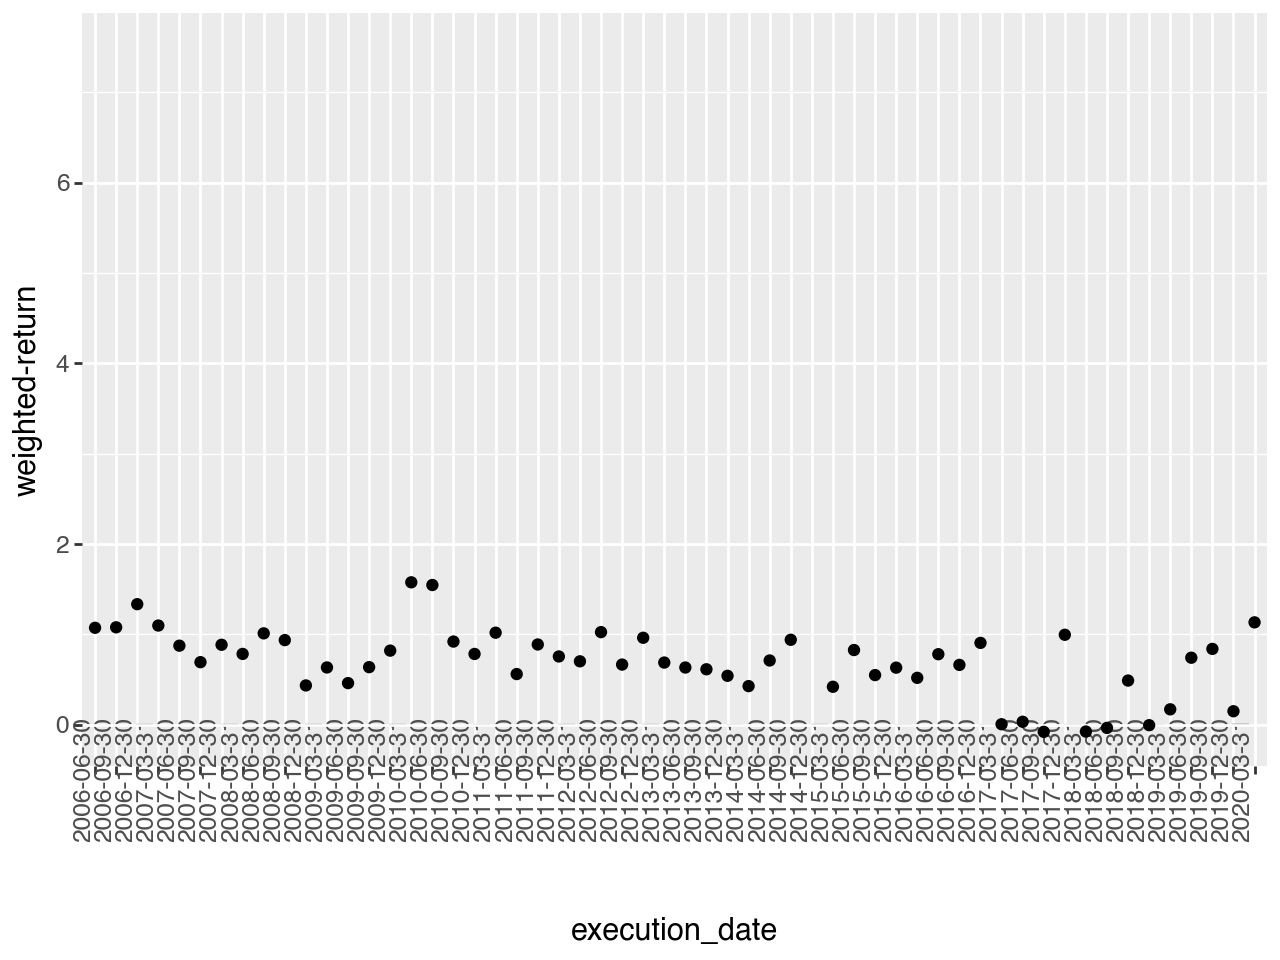

In [212]:
ggplot(test_results_final_tree2) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1)) + scale_y_continuous(limits=(None, 7.5))


In [153]:
train_results_final_tree2.head()

,binary_logloss,weighted-return,n_trees,execution_date
39,0.171713,0.892006,39,2006-06-30
39,0.278996,0.350750,39,2006-09-30
39,0.334947,0.792526,39,2006-12-30
39,0.369191,0.917356,39,2007-03-31
39,0.387766,0.964462,39,2007-06-30


In [156]:
train_results_final_tree2.tail()

,binary_logloss,weighted-return,n_trees,execution_date
39,0.624280,0.472214,39,2019-03-31
39,0.623344,0.404293,39,2019-06-30
39,0.622242,0.484938,39,2019-09-30
39,0.623151,0.428794,39,2019-12-30
39,0.618439,0.487939,39,2020-03-31


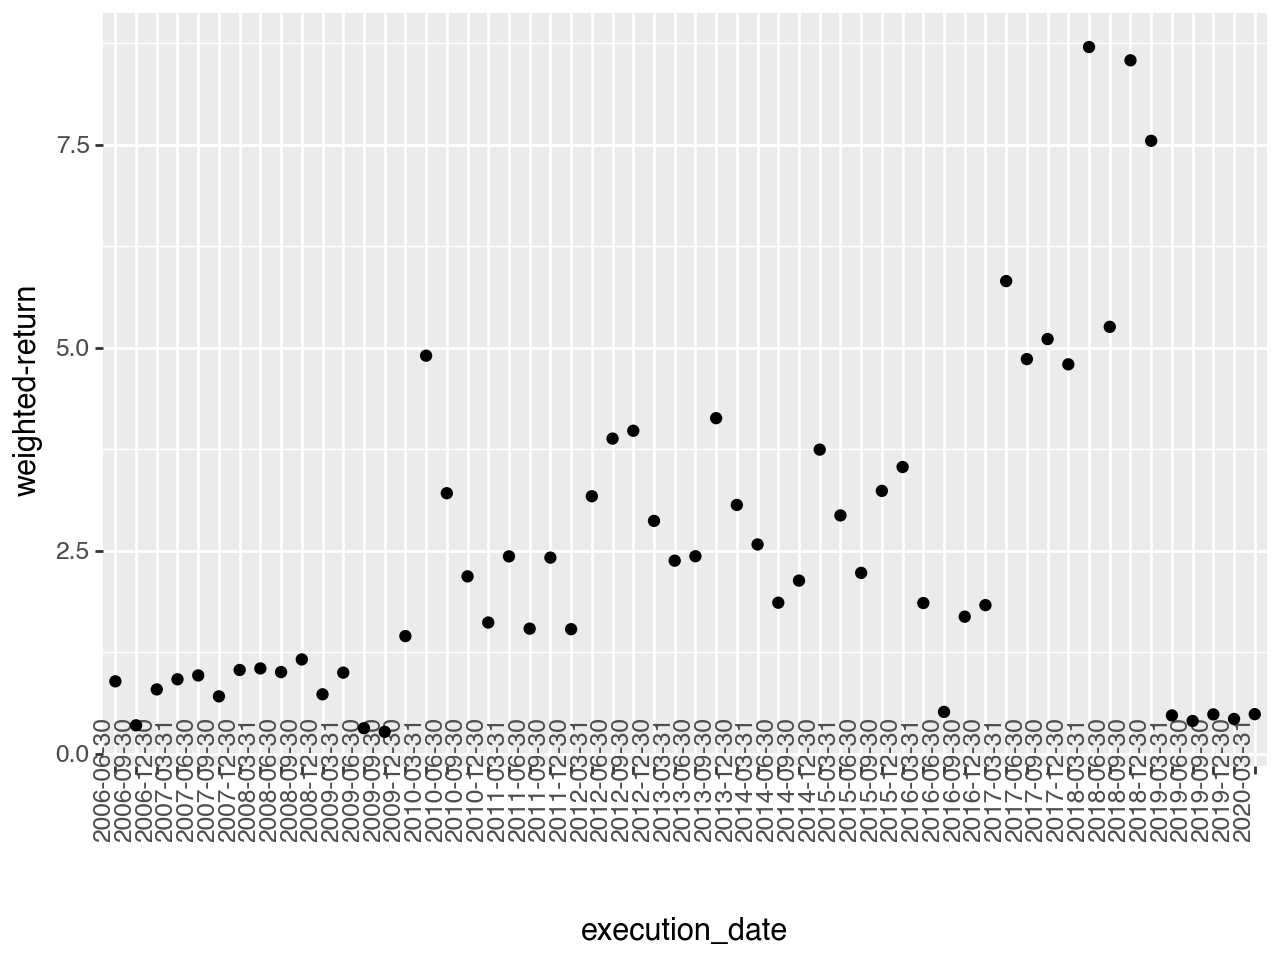

In [159]:
ggplot(train_results_final_tree2) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))


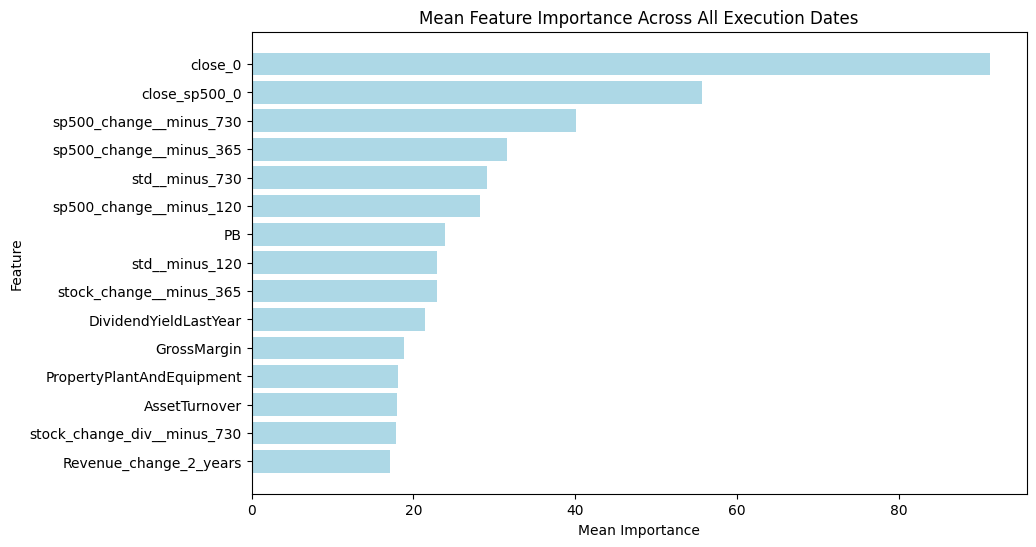

In [154]:
mean_feature_importance2 = calculate_mean_feature_importance(all_models2, top=15)

plot_mean_feature_importance(mean_feature_importance2)

In [213]:
def train_model(train_set,test_set,n_estimators = 50):

    columns_to_remove = get_columns_to_remove()
    
    X_train = train_set.drop(columns = columns_to_remove, errors = "ignore")
    X_test = test_set.drop(columns = columns_to_remove, errors = "ignore")
    
    
    y_train = train_set["target"]
    y_test = test_set["target"]

    lgb_train = lgb.Dataset(X_train,y_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
    
    eval_result = {}
    
 
    objective = 'binary'
    metric = 'custom' 
    params = {
             "random_state":1, 
             "verbosity": -1,
             "n_jobs":10, 
             "n_estimators":n_estimators,
             "objective": objective,
             "max_depth": 5,
            "min_data_in_leaf": 20,
             "lambda_l1": 0.1,
             "metric": metric}
    
    model = lgb.train(params = params,train_set = lgb_train,
                      valid_sets = [lgb_test,lgb_train],
                      feval = [top_wt_performance],
                      callbacks = [lgb.record_evaluation(eval_result = eval_result)])
    return model,eval_result,X_train,X_test

In [214]:
all_results3 = {}
all_predicted_tickers_list3 = []
all_models3 = {}

for execution_date in execution_dates:
    print(execution_date)
    all_results3,all_predicted_tickers_list3,all_models3,model3,X_train,X_test = run_model_for_execution_date(execution_date,all_results3,all_predicted_tickers_list3,all_models3,n_trees,False)
all_predicted_tickers3 = pd.concat(all_predicted_tickers_list3) 

2005-06-30 00:00:00
2005-09-30 00:00:00
2005-12-30 00:00:00
2006-03-31 00:00:00
2006-06-30 00:00:00
2006-09-30 00:00:00
2006-12-30 00:00:00
2007-03-31 00:00:00
2007-06-30 00:00:00
2007-09-30 00:00:00
2007-12-30 00:00:00
2008-03-31 00:00:00
2008-06-30 00:00:00
2008-09-30 00:00:00
2008-12-30 00:00:00
2009-03-31 00:00:00
2009-06-30 00:00:00
2009-09-30 00:00:00
2009-12-30 00:00:00
2010-03-31 00:00:00
2010-06-30 00:00:00
2010-09-30 00:00:00
2010-12-30 00:00:00
2011-03-31 00:00:00
2011-06-30 00:00:00
2011-09-30 00:00:00
2011-12-30 00:00:00
2012-03-31 00:00:00
2012-06-30 00:00:00
2012-09-30 00:00:00
2012-12-30 00:00:00
2013-03-31 00:00:00
2013-06-30 00:00:00
2013-09-30 00:00:00
2013-12-30 00:00:00
2014-03-31 00:00:00
2014-06-30 00:00:00
2014-09-30 00:00:00
2014-12-30 00:00:00
2015-03-31 00:00:00
2015-06-30 00:00:00
2015-09-30 00:00:00
2015-12-30 00:00:00
2016-03-31 00:00:00
2016-06-30 00:00:00
2016-09-30 00:00:00
2016-12-30 00:00:00
2017-03-31 00:00:00
2017-06-30 00:00:00
2017-09-30 00:00:00


In [215]:
test_results3 = parse_results_into_df("valid_0")
train_results3 = parse_results_into_df("training")


In [216]:
test_results_final_tree3 = test_results3.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")
train_results_final_tree3 = train_results3.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")

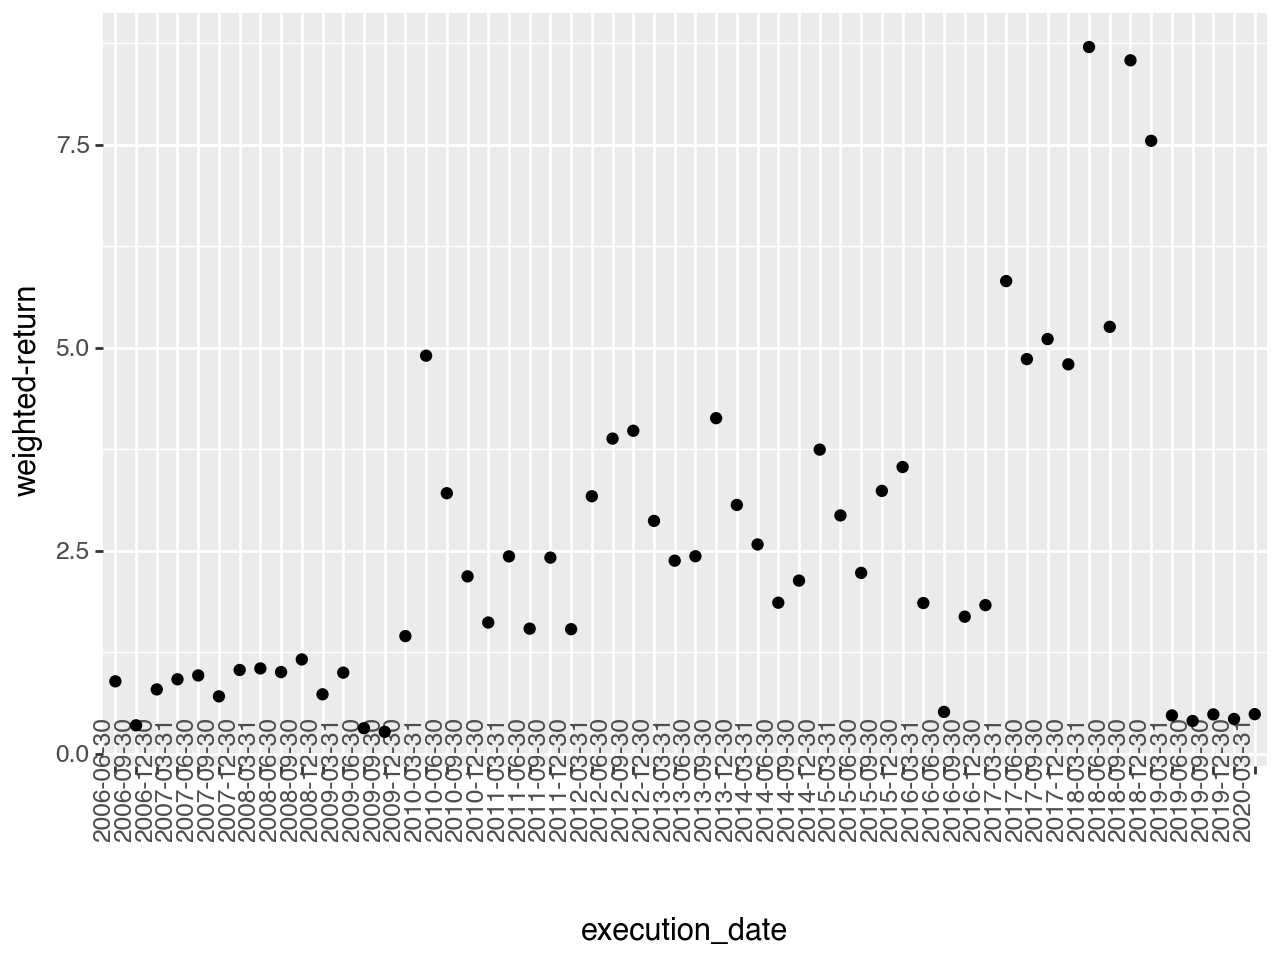

In [217]:
ggplot(train_results_final_tree3) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))


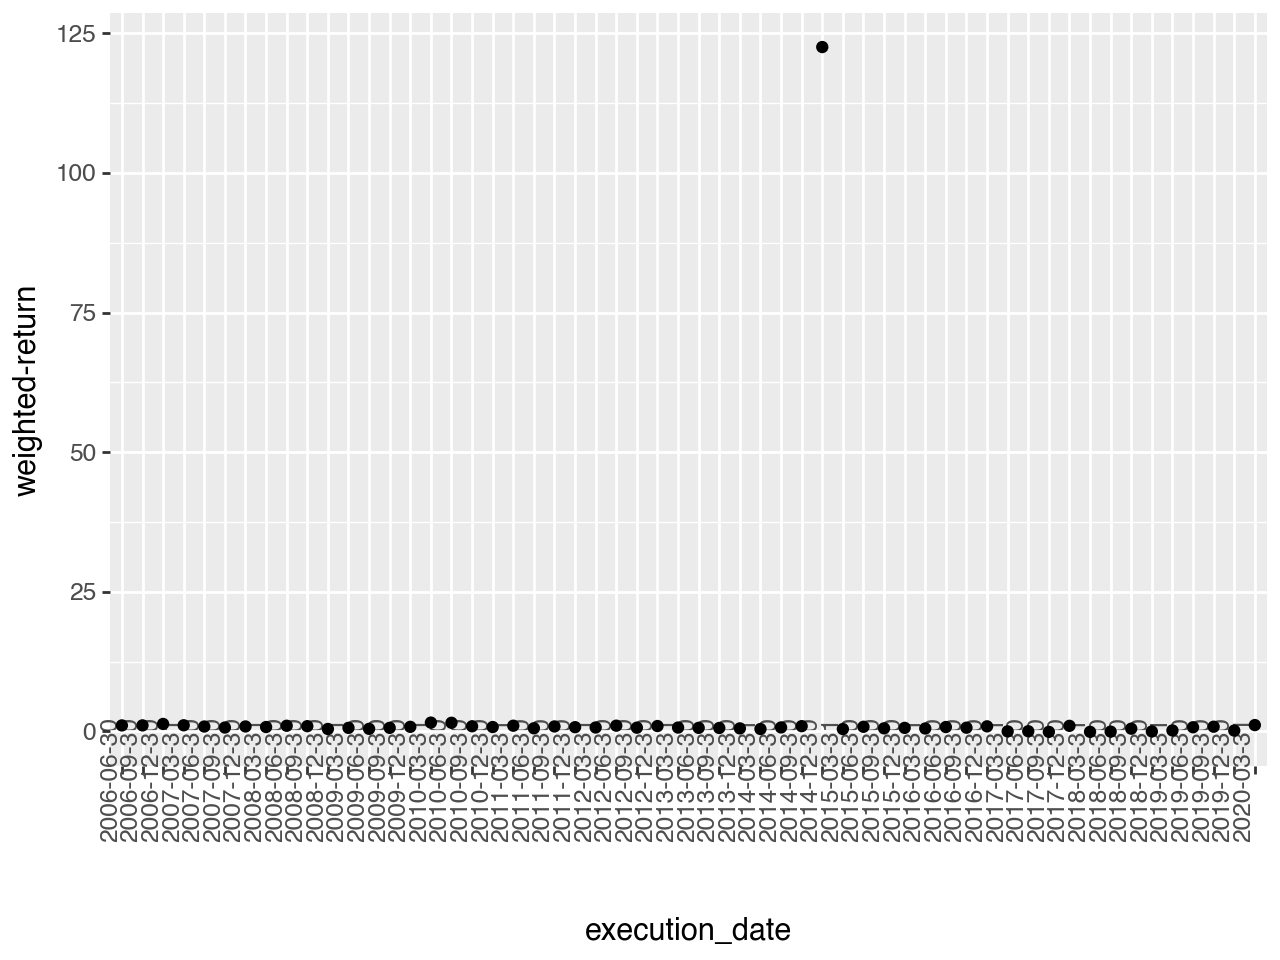

In [218]:
ggplot(test_results_final_tree3) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))


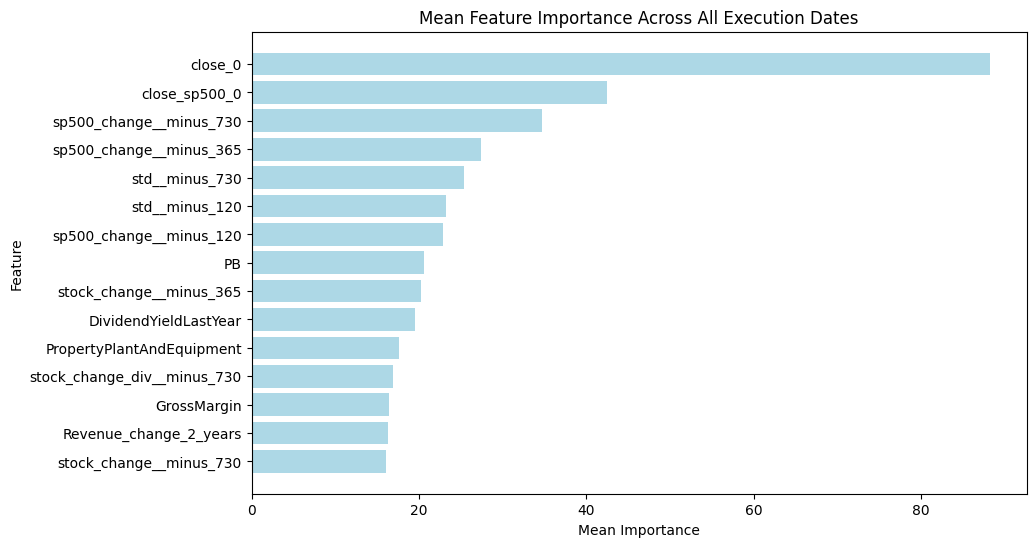

In [220]:
mean_feature_importance3 = calculate_mean_feature_importance(all_models3, top=15)

plot_mean_feature_importance(mean_feature_importance3)

include some changes